## Seminar 01: Dealing with Word Embeddings

Today we gonna play with word embeddings: train our own little embedding, load one from   gensim model zoo and use it to visualize text corpora.

This whole thing is gonna happen on top of embedding dataset.

__Requirements:__ if you're running locally, in the selected environment run the following command:

```pip install --upgrade nltk gensim bokeh umap-learn```


In [ ]:
!pip install --upgrade nltk gensim bokeh umap-learn

In [2]:
import itertools
import string

import numpy as np
import umap
from nltk.tokenize import WordPunctTokenizer

from matplotlib import pyplot as plt

from IPython.display import clear_output

In [ ]:
# download the data:
!wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora.txt -nc
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

In [4]:
data = list(open("./quora.txt", encoding="utf-8"))
data[50]

"What TV shows or books help you read people's body language?\n"

__Tokenization:__ a typical first step for an nlp task is to split raw data into words.
The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple str.split won't do.

Let's use __`nltk`__ - a library that handles many nlp tasks like tokenization, stemming or part-of-speech tagging.

In [5]:
tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


In [6]:
# TASK: lowercase everything and extract tokens with tokenizer.
# data_tok should be a list of lists of tokens for each line in data.

data_tok = [tokenizer.tokenize(l.lower()) for l in data]

Let's peek at the result:

In [7]:
' '.join(data_tok[0])

"can i get back with my ex even though she is pregnant with another guy ' s baby ?"

Small check that everything is alright

In [8]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, data_tok))), "please make sure to lowercase the data"

__Word vectors:__ as the saying goes, there's more than one way to train word embeddings. There's Word2Vec and GloVe with different objective functions. Then there's fasttext that uses character-level models to train word embeddings.

The choice is huge, so let's start someplace small: __gensim__ is another NLP library that features many vector-based models incuding word2vec.

In [9]:
from gensim.models import Word2Vec
model = Word2Vec(data_tok,
                #  size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

In [10]:
# now you can get word vectors !
model.get_vector('anything')

array([-2.1106367 , -0.286981  ,  0.72081536,  0.75184435,  0.14730933,
        2.0682945 ,  2.3358083 , -0.44215485,  0.32332596,  0.38619104,
       -0.7143642 ,  0.21797074,  2.2489    , -2.4085546 ,  0.51246905,
        0.16406812, -1.8341796 , -0.853974  , -0.1760799 , -1.4418676 ,
        0.2979285 ,  0.34922415,  0.04965775,  2.1984706 , -2.3814423 ,
       -1.0302821 ,  0.6570601 , -0.96060205, -1.3480322 ,  0.3546429 ,
       -0.45123968, -0.5400299 , -2.050367  , -2.1452947 ,  0.5564627 ,
        0.8020738 ,  0.61110395,  2.72053   , -1.2797346 , -0.00460638,
        0.44336095, -0.54941803,  0.48330438,  2.1158173 , -0.5957624 ,
       -0.14913984, -1.9455585 , -0.00446996, -0.18953359,  0.6962221 ,
        0.89712125, -0.08021004,  2.1260228 ,  0.8359791 , -0.59554553,
        0.11572786, -0.21519493, -1.0877342 ,  0.5228385 , -2.0938742 ,
       -1.4153401 , -0.14762624, -0.7039572 , -0.92347556, -1.9630723 ,
        1.1222856 ,  1.5787197 ,  0.04549687,  0.664428  , -0.86

In [11]:
# or query similar words directly. Go play with it!
model.most_similar('bread')

[('rice', 0.898751974105835),
 ('potato', 0.8760380744934082),
 ('cheese', 0.8711096048355103),
 ('butter', 0.8649253249168396),
 ('fruit', 0.8554353713989258),
 ('chocolate', 0.8544111847877502),
 ('sauce', 0.8518035411834717),
 ('corn', 0.8426517844200134),
 ('chicken', 0.8374917507171631),
 ('noodles', 0.8354123830795288)]

### Using pre-trained model

Took it a while, huh? Now imagine training life-sized (100~300D) word embeddings on gigabytes of text: wikipedia articles or twitter posts.

Thankfully, nowadays you can get a pre-trained word embedding model in 2 lines of code (no sms required, promise).

In [12]:
import gensim.downloader as api
model = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [13]:
model.most_similar(positive=["coder", "money"], negative=["brain"])

[('realtor', 0.8265186548233032),
 ('gfx', 0.8249695897102356),
 ('caterers', 0.798202395439148),
 ('beatmaker', 0.7936854362487793),
 ('recruiter', 0.7892400026321411),
 ('sfi', 0.784467339515686),
 ('sosh', 0.7840632796287537),
 ('promoter', 0.7838250994682312),
 ('smallbusiness', 0.7786215543746948),
 ('promoters', 0.77646803855896)]

### Visualizing word vectors

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 30D+ space and we humans are more used to 2-3D.

Luckily, we machine learners know about __dimensionality reduction__ methods.

Let's use that to plot 1000 most frequent words

In [14]:
words = model.index_to_key[:1000]

In [15]:
print(words[::100])

['<user>', '_', 'please', 'apa', 'justin', 'text', 'hari', 'playing', 'once', 'sei']


In [16]:
# for each word, compute it's vector with model
word_vectors = model[words]

In [17]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 25)
assert np.isfinite(word_vectors).all()

In [18]:
word_vectors.shape

(1000, 25)

#### Linear projection: PCA

The simplest linear dimensionality reduction method is __P__rincipial __C__omponent __A__nalysis.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/pca_fish.png" style="width:30%">


Under the hood, it attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;



In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(2)
scaler = StandardScaler()
scaler.fit_transform(word_vectors)

array([[ 0.47980028,  0.6406262 , -0.15624179, ..., -0.5440411 ,
        -0.06122227,  1.0273207 ],
       [ 0.5753044 , -1.6861335 , -0.64609426, ..., -0.7690076 ,
         0.30978432,  0.5488884 ],
       [ 1.1457713 , -0.10828368, -0.0906046 , ..., -0.59285253,
        -0.6055395 ,  0.9746976 ],
       ...,
       [ 0.12266244,  0.05917931,  0.04191763, ...,  0.96519834,
        -0.7289175 , -0.07264951],
       [ 2.017307  ,  1.4118614 , -0.83041203, ..., -0.2562142 ,
        -1.2385352 , -0.9925006 ],
       [-0.4231235 , -0.09085197,  0.87548643, ...,  0.87517923,
         0.03810331,  0.4126311 ]], dtype=float32)

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(2)
scaler = StandardScaler()
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = scaler.fit_transform(pca.fit_transform(word_vectors))
# and maybe MORE OF YOUR CODE here :)

In [21]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1.0 - word_vectors_pca.std(0))) < 1e-2, "points must have unit variance"

#### Let's draw it!

In [22]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [23]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

figure(id='p1004', ...)

### Visualizing neighbors with UMAP
PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use UMAP, which is itself an embedding method. Here you can read __[more on UMAP (ru)](https://habr.com/ru/company/newprolab/blog/350584/)__ and on __[t-SNE](https://distill.pub/2016/misread-tsne/)__, which is also an embedding.

In [24]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(word_vectors) # преобразовываем

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [25]:
draw_vectors(embedding[:, 0], embedding[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

figure(id='p1055', ...)

### Visualizing phrases

Word embeddings can also be used to represent short phrases. The simplest way is to take __an average__ of vectors for all tokens in the phrase with some weights.

This trick is useful to identify what data are you working with: find if there are any outliers, clusters or other artefacts.

Let's try this new hammer on our data!


In [26]:
VECTOR_SIZE = len(model['_'])

In [27]:
'бебра' in model

False

In [28]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros

    vector = np.zeros([VECTOR_SIZE], dtype='float32')
    phrase_tokenized = tokenizer.tokenize(phrase)
    phrase_vectors = [model[x] for x in phrase_tokenized if x in model]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)

    # YOUR CODE

    return vector



In [29]:
get_phrase_embedding(data[402687])

array([-2.4530101e-01,  2.7792186e-01,  1.9431020e-01,  1.5068591e-01,
       -1.3707921e-01, -3.3016500e-01,  1.1931340e+00,  1.5921301e-01,
       -3.1031051e-01, -2.3458600e-03, -1.3483360e-01,  5.2113008e-02,
       -4.8041296e+00, -2.0020501e-01, -3.5438800e-01, -1.6206822e-01,
        4.2486858e-01, -8.4441108e-01, -5.7212323e-01, -1.7153969e-01,
       -4.7212900e-03,  1.7244989e-01, -1.7393640e-01,  2.9092440e-01,
       -4.7086400e-01], dtype=float32)

In [30]:
vector = get_phrase_embedding("I'm very sure. This never happened to me before...")

In [31]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[::len(data) // 1000]

# compute vectors for chosen phrases and turn them to numpy array
phrase_vectors = np.asarray([get_phrase_embedding(x) for x in chosen_phrases]) # YOUR CODE

In [32]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [33]:
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize

phrase_vectors_2d = umap.UMAP(n_neighbors=3).fit_transform(phrase_vectors) # преобразовываем

# phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [34]:
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1],
             phrase=[phrase[:50] for phrase in chosen_phrases],
             radius=20,)

figure(id='p1106', ...)

Finally, let's build a simple "similar question" engine with phrase embeddings we've built.

In [35]:
# compute vector embedding for all lines in data
data_vectors = np.vstack([get_phrase_embedding(l) for l in data])

In [36]:
norms = np.linalg.norm(data_vectors, axis=1)

In [37]:
printable_set = set(string.printable)

In [38]:
data_subset = [x for x in data if set(x).issubset(printable_set)]

In [39]:
def find_nearest(query, k=10):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    similarity should be measured as cosine between query and line embedding vectors
    hint: it's okay to use global variables: data and data_vectors. see also: np.argpartition, np.argsort
    """
    # YOUR CODE
    query_vector = get_phrase_embedding(query)
    dists = data_vectors.dot(query_vector[:, None])[:, 0] / ((norms+1e-16)*np.linalg.norm(query_vector))
    nearest_elements = dists.argsort(axis=0)[-k:][::-1]
    out = [data[i] for i in nearest_elements]
    return out# <YOUR CODE: top-k lines starting from most similar>

In [40]:
results = find_nearest(query="How do i enter the matrix?", k=10)

print(''.join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[0] == 'How do I get to the dark web?\n'
# assert results[3] == 'What can I do to save the world?\n'

How do I get to the dark web?
From where do I download PES 2015 for the PC?
How do I connect the ASUS_T00Q to my PC?
How do I download the APK from the Google Play store to a PC?
How do you upgrade the RAM of a MacBook Pro to 16GB?
How do you print the gridlines in Excel 2007?
How do you print the gridlines in Excel 2010?
How do you print the gridlines in Excel 2003?
I want to connect 2 sets of speakers to my laptop. How do I do it?
How do you transfer music from a computer to iTunes?



In [41]:
find_nearest(query="How does Trump?", k=10)

['What does CANA PROFILE IN TECHMAHINDRA?\n',
 'What does Inefficiency?\n',
 'How does America WIN?\n',
 'Why does Net Neutrality Matters?\n',
 'Why does pyschopath triangulate?\n',
 'How does Unity 3D Work?\n',
 'How does Augmented Reality Work?\n',
 'What does VMV?\n',
 'How does Enterprise Mobile Solution Benefit Businesses?\n',
 'In Naruto, what does Konoha mean?\n']

In [42]:
find_nearest(query="Why don't i ask a question myself?", k=10)

["Why don't my parents listen to me?\n",
 "Why don't people answer me on Quora?\n",
 "Why don't I like people touching me?\n",
 "Why she don't interact with me?\n",
 "Why don't people appreciate me?\n",
 "Can I ask a girl out that I don't know?\n",
 "Why do I think my parents don't care about me?\n",
 "How do I start a conversation with a girl I don't know?\n",
 "Why don't you own a gun?\n",
 "Why can't I take a joke?\n"]

In [43]:
from sklearn.cluster import DBSCAN, KMeans

In [44]:
kmeans = KMeans(3)

In [45]:
labels = kmeans.fit_predict(np.asarray(phrase_vectors))

In [46]:
_colors = ['red', 'green', 'blue']

In [47]:
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1], color=[_colors[l] for l in labels],
             phrase=[phrase[:50] for phrase in chosen_phrases],
             radius=20,)

figure(id='p1157', ...)

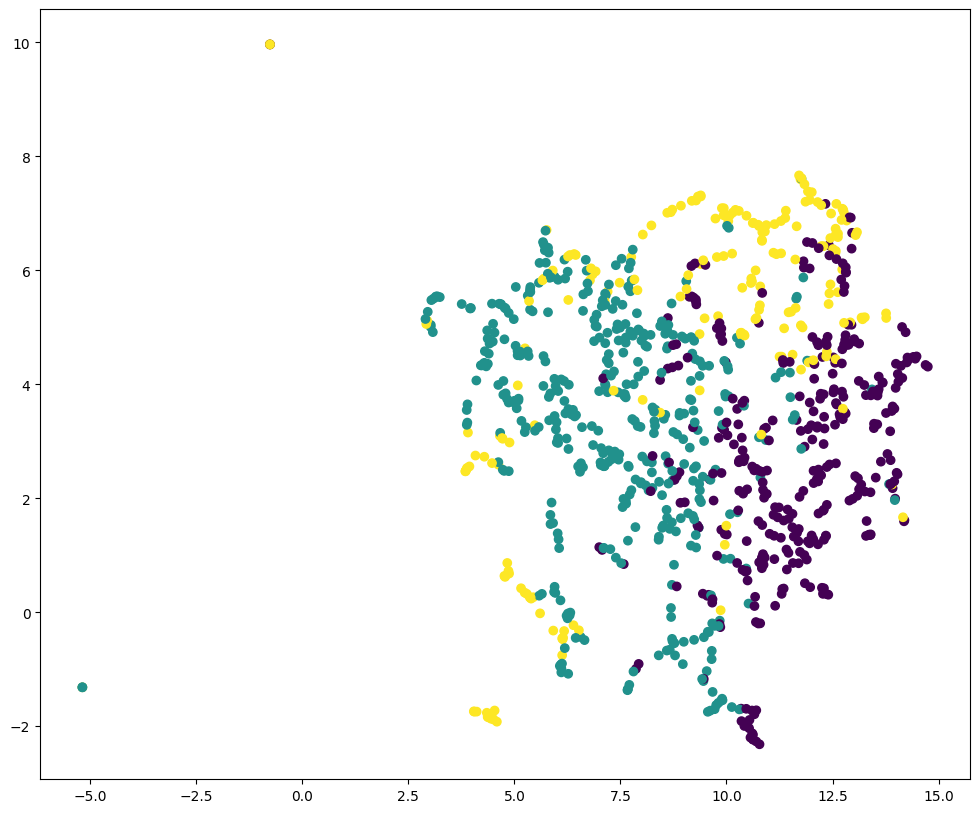

In [48]:
plt.figure(figsize=(12, 10))
plt.scatter(phrase_vectors_2d[:,0], phrase_vectors_2d[:, 1], c=labels.astype(float))

__Now what?__
* Try running TSNE instead of UMAP (it takes a long time)
* Try running UMAP or TSNEon all data, not just 1000 phrases
* See what other embeddings are there in the model zoo: `gensim.downloader.info()`
* Take a look at [FastText](https://github.com/facebookresearch/fastText) embeddings
* Optimize find_nearest with locality-sensitive hashing: use [nearpy](https://github.com/pixelogik/NearPy) or `sklearn.neighbors`.


